In [1]:
import pickle
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# dir = 'weibo'
dir = 'citation'
valid = pickle.load(open("../data/cas2vec/"+dir+"/valid_ana.pkl",'rb'))
test = pickle.load(open("../data/cas2vec/"+dir+"/test_ana.pkl",'rb'))
valid.keys(),test.keys()

(dict_keys(['outputs_prediction', 'outputs_true', 'graph_hidden', 'rnn_hidden', 'graph_info', 'ptr']),
 dict_keys(['outputs_prediction', 'outputs_true', 'graph_hidden', 'rnn_hidden', 'graph_info', 'ptr']))

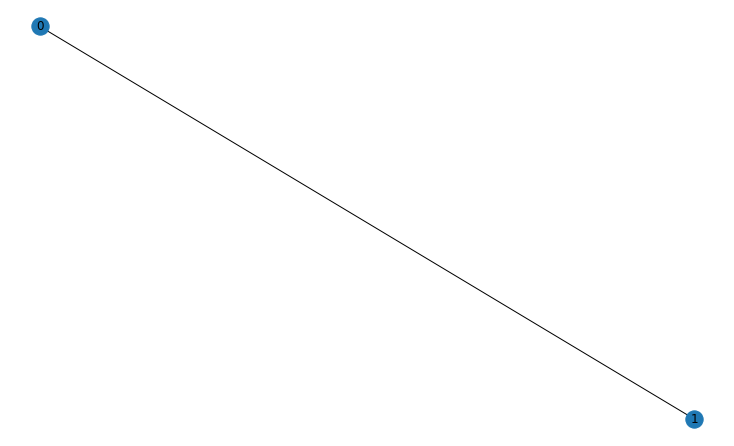

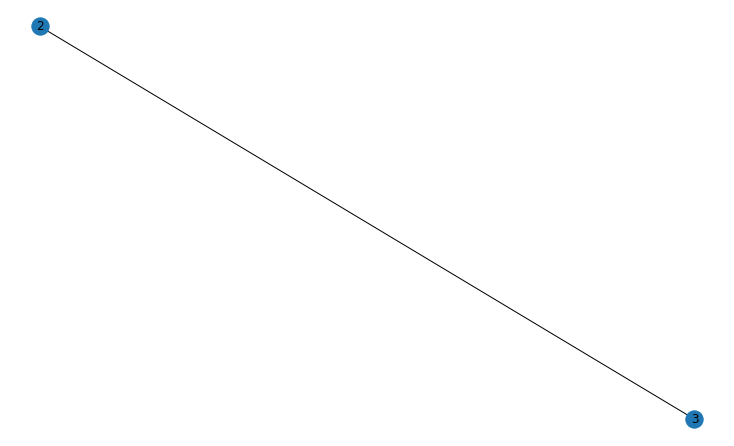

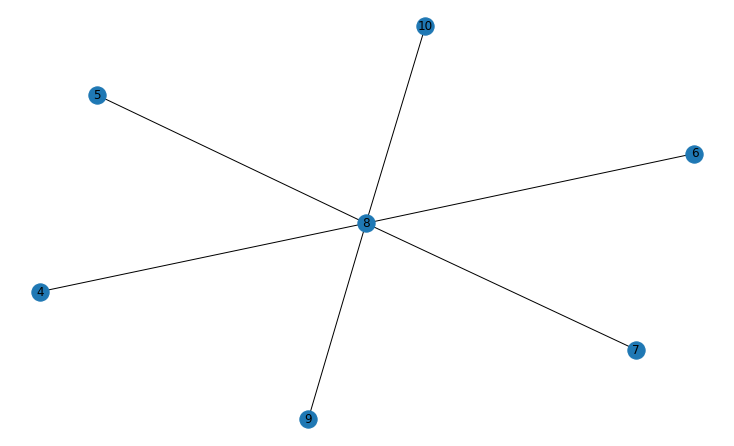

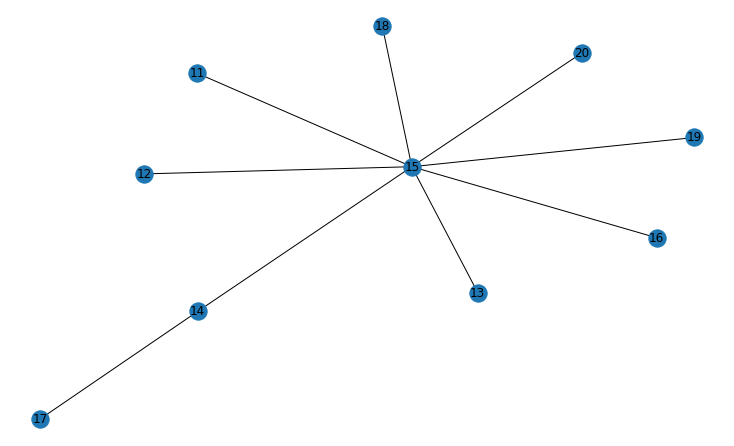

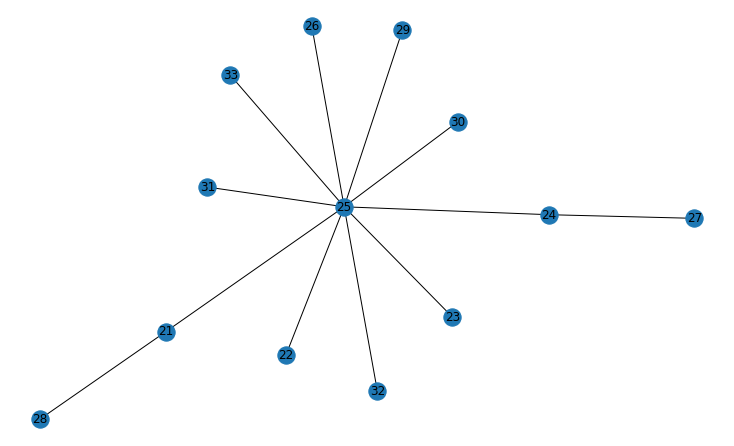

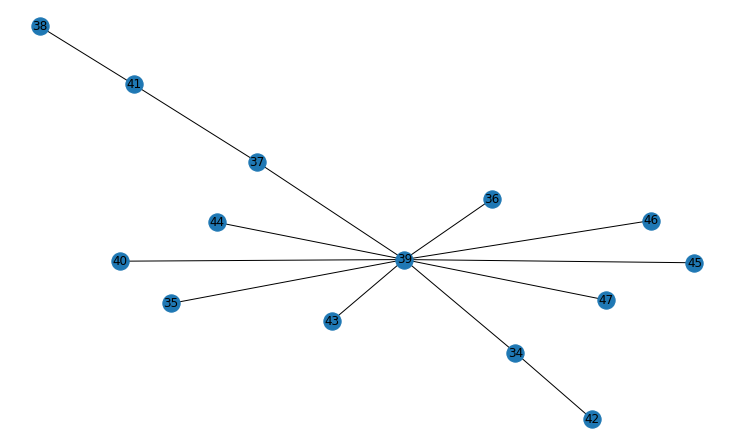

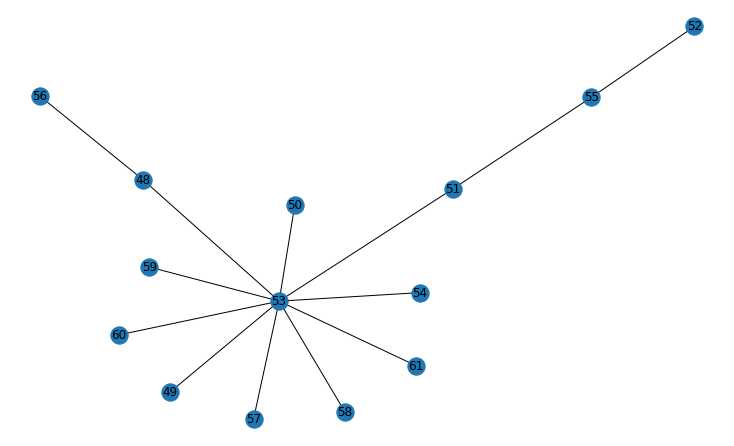

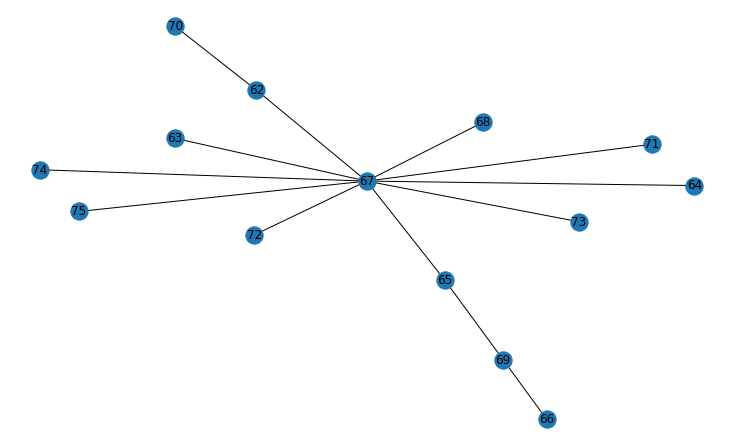

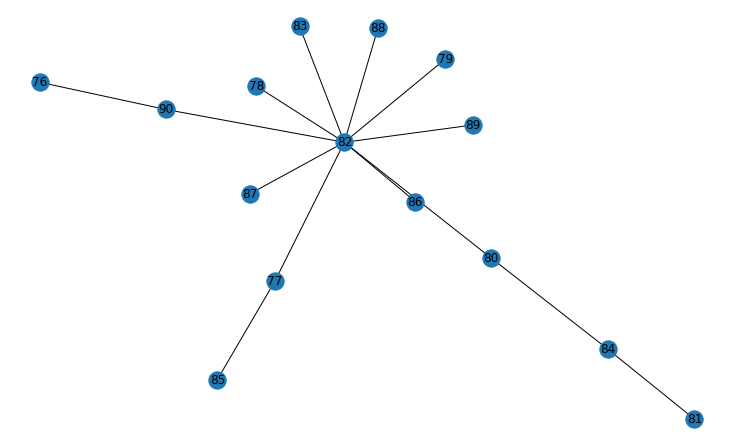

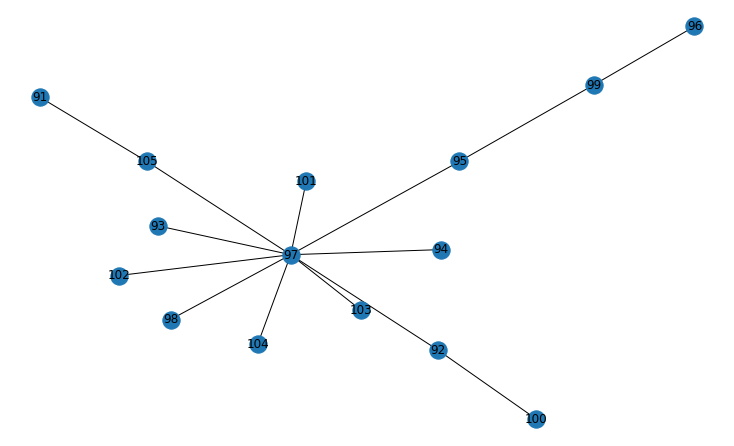

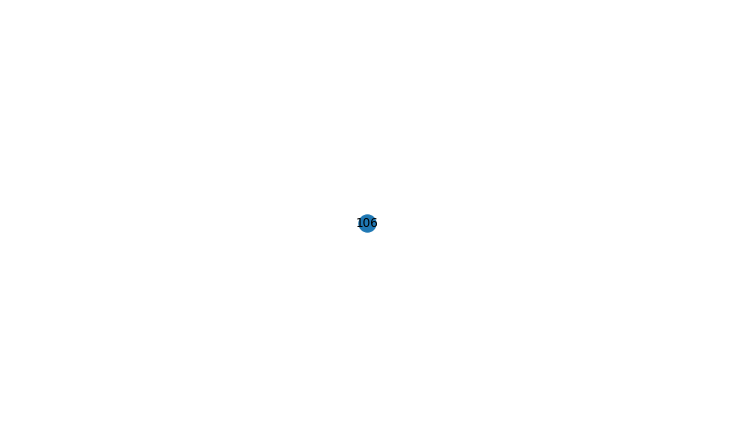

In [3]:
# print(valid['graph_info'][0][1])
idx = 6
split_at = valid['ptr'][idx]
example_graph = np.array(valid['graph_info'][idx][0])
# example_graph = example_graph[:,:100]
plt_num=11
for at in range(len(split_at)-1):
    g = nx.Graph()
    nodes = range(split_at[at],split_at[at+1])
    for i in example_graph.T[:,:]:
        if i[0] in nodes or i[1] in nodes:
            g.add_nodes_from(i)
            g.add_edge(i[0],i[1])
    plt.figure(figsize=(10,6))
    nx.draw(g,with_labels=True)
    plt.show()
    plt.close()
    plt_num-=1
    if plt_num==0:
        break

In [8]:
record_w = {}
idx = 2  # batch num # 15 is complicated

split_at = valid['ptr'][idx]
# if loc > split_at[-1]:
#     idx+=1
#     continue
example_graph = np.array(valid['graph_info'][idx][0])
atten_link = np.array((valid['graph_info'][idx][1][0]).tolist())
atten_w =  np.array((valid['graph_info'][idx][1][1]).tolist())
atten_w = np.sum(atten_w,axis=1)
# atten_w = atten_w.T[0]
e_w={}
local_e_w = {}
for i, e in enumerate(atten_link.T):
    e_w['{}'.format(e)]=atten_w[i]
# example_graph = example_graph[:,:100]


In [12]:
list(e_w.keys())[:10]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

1


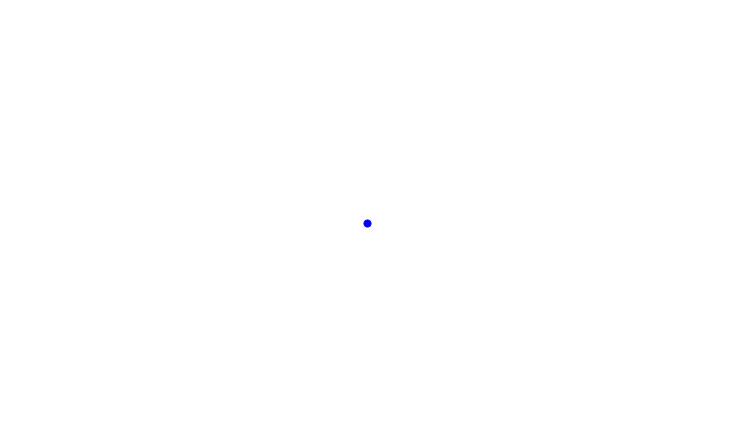

3


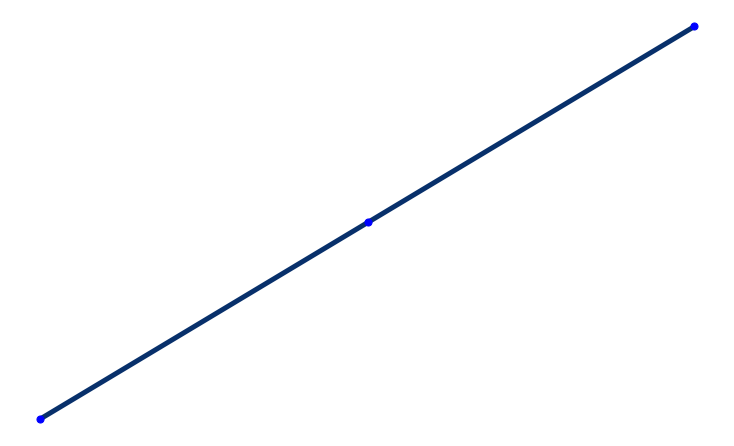

5


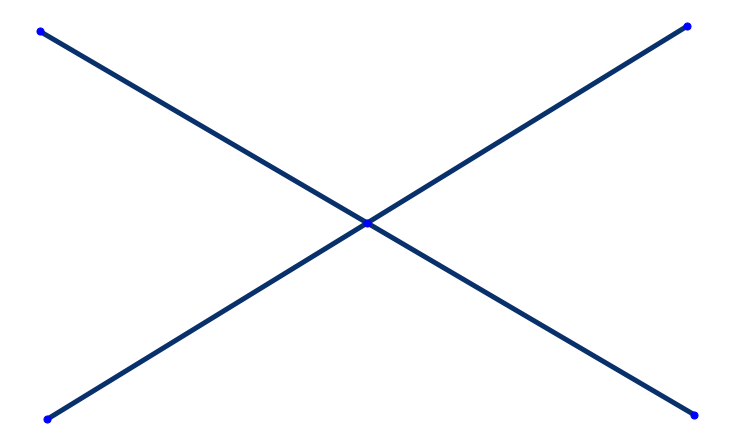

8


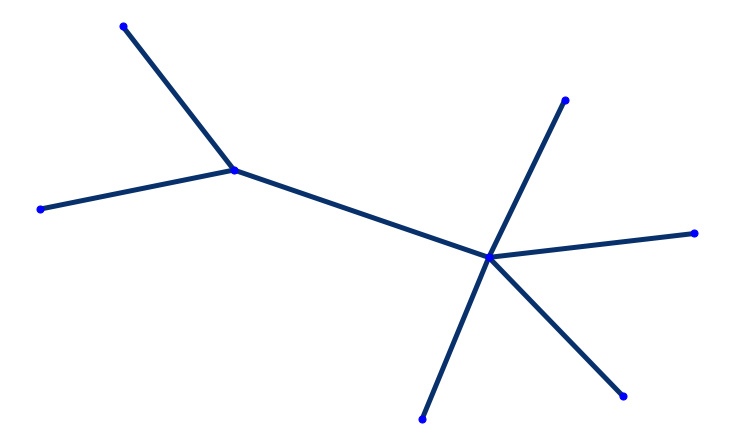

9


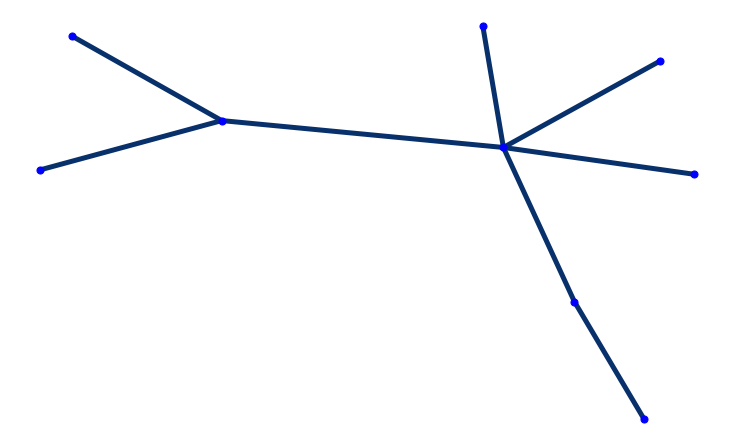

11


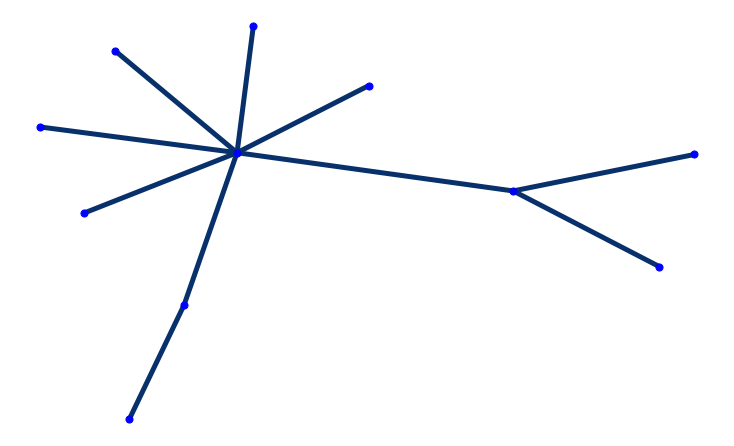

11


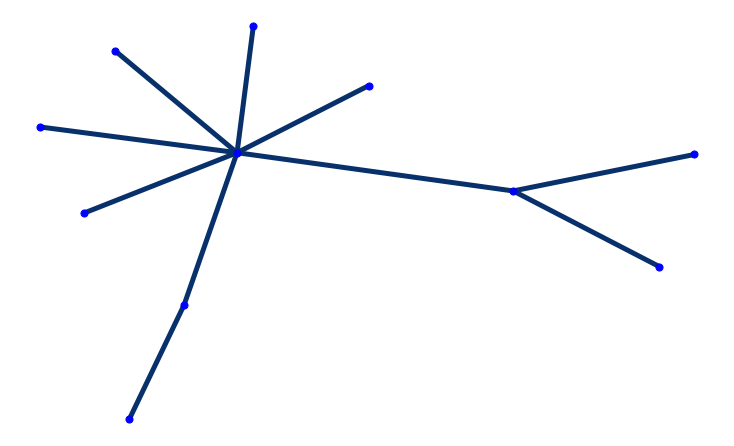

11


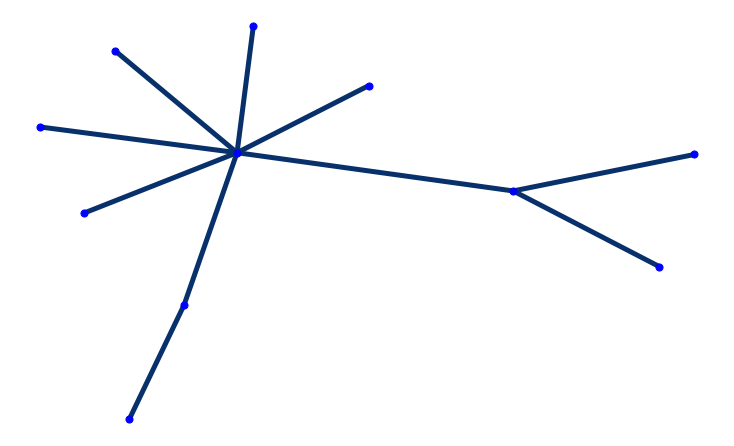

12


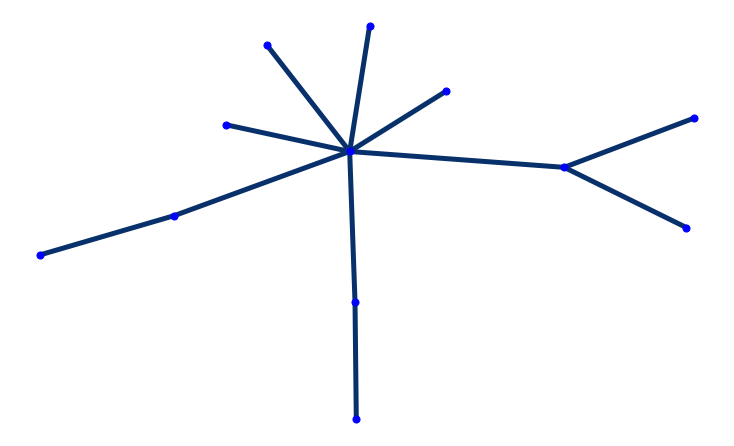

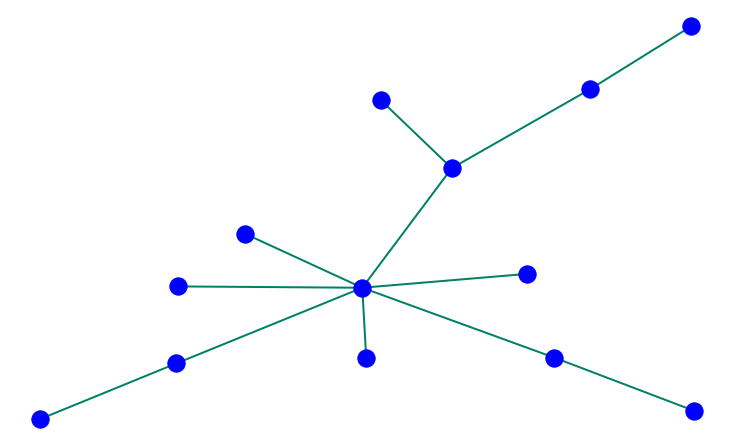

{0: [0], 1: [1, 2, 3], 2: [4, 5, 6, 7, 8], 3: [9, 10, 11, 12, 13, 14, 15, 16], 4: [17, 18, 19, 20, 21, 22, 23, 24, 25], 5: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], 6: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 7: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], 8: [59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], 9: [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]}


In [11]:
import networkx as nx
import matplotlib.pyplot as plt

plt_num=0

subg_id={}
for at in range(len(split_at)-1):
    g = nx.Graph()
    nodes = list(range(split_at[at],split_at[at+1]))
    subg_id[plt_num]=nodes
    for i in example_graph.T[:,:]:
        if i[0] in nodes and i[1] in nodes:
            g.add_nodes_from(i)
            g.add_edge(i[0],i[1])
            # local_e_w['{}'.format(i)]=e_w['{}'.format(i)]
    plt_num+=1
    if plt_num>=10:
        break   
    for u,v,d in g.edges(data=True):
        d['weight'] = 1
    plt.figure(figsize=(10,6)) 
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    print(len(g))
    pos = nx.spring_layout(g,seed=2)
    nx.draw(g, pos, edgelist=edges,node_color='b',node_size=50, edge_color=weights, width=5, edge_cmap=plt.cm.Blues_r)

    plt.show()
for u,v,d in g.edges(data=True):
    d['weight'] = 1


plt.figure(figsize=(10,6)) 
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())

pos = nx.spring_layout(g)
nx.draw(g, pos, node_color='b', edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.summer)

plt.show()
print(subg_id)
# break

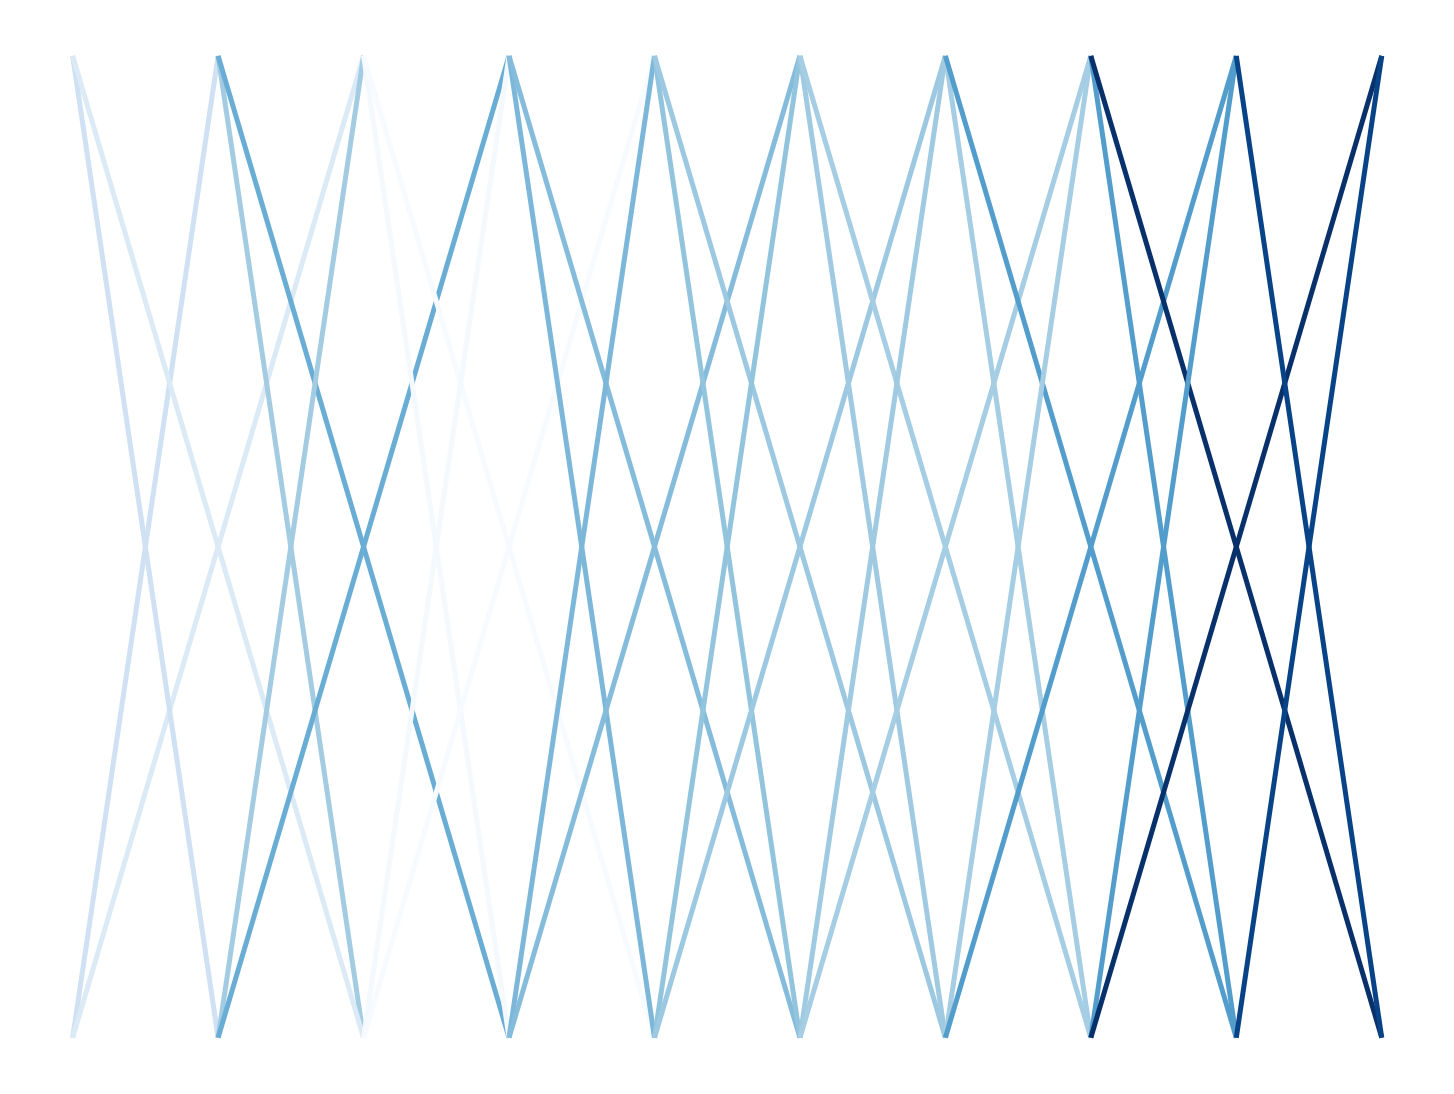

In [12]:
graph_level_atten={}
graph_level_link=[]
check = {}
for k,v in subg_id.items():
    tmp=range(k-2,k+3)
    gd=[]
    for i in tmp :
        if i<0 or i>=10 or i==k:
            continue
        else:
            gd.append(i)
    for i in gd:
        for me in subg_id[k]:
            for they in subg_id[i]:
                try:
                    graph_level_atten['{}'.format([k,i+10])]+=e_w['{}'.format(np.array([me,they]))]
                    check['{}'.format([k,i])]+=e_w['{}'.format(np.array([me,they]))]
                    graph_level_atten['{}'.format([k+10,i])]+=e_w['{}'.format(np.array([me,they]))]
                except:
                    graph_level_atten['{}'.format([k,i+10])]=e_w['{}'.format(np.array([me,they]))]
                    check['{}'.format([k,i])]=e_w['{}'.format(np.array([me,they]))]
                    graph_level_atten['{}'.format([k+10,i])]=e_w['{}'.format(np.array([me,they]))]
                    graph_level_link.append([k,i+10])
                    graph_level_link.append([k+10,i])
    for i in gd:
                graph_level_atten['{}'.format([k,i+10])]/=len(subg_id[k])
                graph_level_atten['{}'.format([k+10,i])]/=len(subg_id[k])
                check['{}'.format([k,i])]/=len(subg_id[k])
                
# print(graph_level_atten)
# print(check)
    # print(gd)
    # break
G_a=nx.Graph()
G_a.add_edges_from(graph_level_link)
for u,v,d in G_a.edges(data=True):
    if '{}'.format([u,v]) in graph_level_atten.keys():
        # print(e_w['{}'.format(np.array([u,v]))])
        d['weight'] = graph_level_atten['{}'.format([u,v])]
    else:
        d['weight'] = 0.01

edges,weights = zip(*nx.get_edge_attributes(G_a,'weight').items())
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G_a)
pos = {}
for i in range(10):
    pos[i]=np.array([i,1])
for i in range(10,20):
    pos[i]=np.array([i-10,3])
nx.draw(G_a, pos, node_color='blue', edgelist=edges,edge_color=weights,node_size=0, width=5, edge_cmap=plt.cm.Blues)
plt.show()

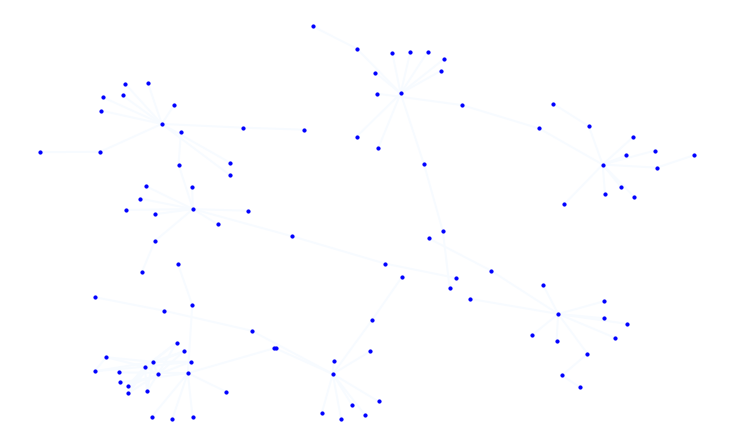

In [10]:
nodes_id=[]
plot_edges = []
for k,v in subg_id.items():
    nodes_id.append(v)
for i in nodes_id[1]:
    for j in nodes_id[0]:
        plot_edges.append([i,j])
for i in nodes_id[1]:
    for j in nodes_id[2]:
        plot_edges.append([i,j])

plot_edges = np.array(plot_edges)
g.add_edges_from(plot_edges)
plt.figure(figsize=(10,6)) 

for u,v,d in g.edges(data=True):
    if '{}'.format(np.array([u,v])) in e_w.keys():
        # print(e_w['{}'.format(np.array([u,v]))])
        d['weight'] = e_w['{}'.format(np.array([u,v]))]
    else:
        d['weight'] = 0.1
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())

pos = nx.spring_layout(g)
nx.draw(g, pos, node_color='b', edgelist=edges,edge_color=weights,node_size=10, width=2, edge_cmap=plt.cm.Blues)

plt.show()

In [39]:
seen_nodes = list(g.nodes())
seen_edges = list(g.edges())

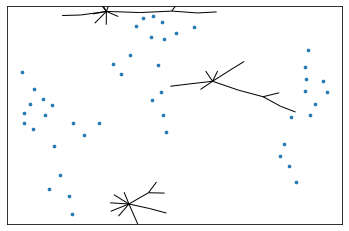

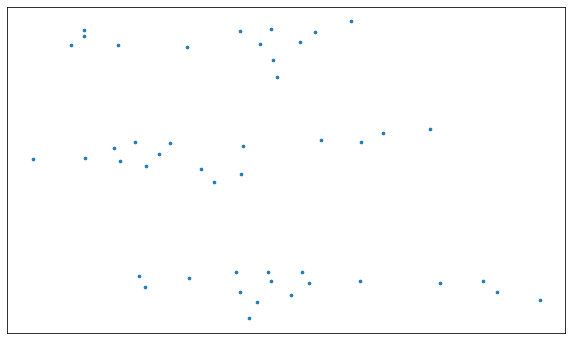

In [37]:

# nx.draw_networkx_nodes(g,nodelist=seen_nodes,node_size=7,pos=nx.spring_layout(g))
# nx.draw_networkx_edges(g,edgelist=seen_edges,pos=nx.spring_layout(g))
# plt.show()
# g_attention = nx.Graph()

atten_edges=[]
atten_weight = []
for e,w in zip(atten_link.T,atten_w):
    if e[0] in seen_nodes and e[1] in seen_nodes:
        if (w)<0.1:
            continue
        atten_edges.append((e[0],e[1]))
        atten_weight.append(w)
g.add_edges_from(atten_edges)
plt.figure(figsize=(10,6))
for e,w in zip(atten_edges,atten_weight):
    nx.draw_networkx_edges(g,edge_color='g',alpha=w,edgelist=[e],pos=nx.spring_layout(g))
nx.draw_networkx_nodes(g,nodelist=seen_nodes,node_size=7,pos=nx.spring_layout(g))
# nx.draw_networkx_edges(g,edgelist=seen_edges,pos=nx.spring_layout(g))


plt.show()

In [ ]:
idx = 9
atten_link = np.array((valid['graph_info'][idx][1][0]).tolist())
atten_w =  np.array((valid['graph_info'][idx][1][1]).tolist())
atten_w = np.sum(atten_w,axis=1)
print(atten_w)
print(np.max(atten_w),np.min(atten_w))
print(len(atten_w))

In [ ]:
print(len(atten_link.T),atten_w)


In [ ]:

ptr = np.concatenate((test['ptr'],valid['ptr']))
test_trues = np.concatenate((test['outputs_true'],valid['outputs_true']))
test_graph_size = []
test_graph_hidden = np.concatenate((test['graph_hidden'],valid['graph_hidden']))
test_rnn_hidden = np.concatenate((test['rnn_hidden'],valid['rnn_hidden']))

n_seq = test['graph_hidden'].shape[2]
hidden_dim = test['graph_hidden'].shape[-1]

for iter in ptr:
    for idx in range(0,len(iter)-1,n_seq):
        one_batch = iter[idx+1:idx+n_seq+1]-iter[idx:idx+n_seq]
        test_graph_size.append(one_batch)
# test_graph_size=np.array(test_graph_size)
test_graph_size=np.log2(np.array(test_graph_size)+1)
# print(test_graph_size.shape)
last_moment = test_graph_size.T[-1]
# print(last_moment)
# print(np.expand_dims(test_graph_size.T[-1],axis=1)-test_graph_size)

In [ ]:
output_pool = []
for outputs in test_graph_hidden:
    outputs = torch.tensor(outputs)
    lstm_output = F.adaptive_max_pool1d(outputs.transpose(1, 2), output_size=1).squeeze()
    output_pool.append(lstm_output.tolist())
output_pool = np.array(output_pool)
output_pool.shape

## graph_hidden-graph_size

In [ ]:
print(test_graph_size.shape,test_graph_hidden.shape)

Hs,Is = shuffle(test_graph_hidden.reshape(-1,hidden_dim),np.power(2,test_graph_size).reshape(-1))
X = TSNE(n_components=2,random_state=42,learning_rate=25,n_iter=6000).fit_transform(Hs[:40000])
sc = plt.scatter(X[:, 0], X[:, 1],s=1, c=Is[:40000], cmap='viridis_r')
plt.colorbar(sc)
plt.show()

## max_pooling-future_growth

In [ ]:
Hs,Is = [],[]
for o,t in zip(output_pool.reshape(-1,hidden_dim),test_trues):
    if t>5:
        continue
    # if t<4:
    #     continue
    Hs.append(o)
    Is.append(np.power(2,t))
Hs=np.array(Hs)
# Hs,Is = shuffle(output_pool.reshape(-1,hidden_dim),test_trues)
print(Hs.shape)
X = TSNE(n_components=2,random_state=42,verbose=1).fit_transform(Hs)
sc = plt.scatter(X[:, 0], X[:, 1],s=3, c=Is, cmap='viridis_r')
plt.colorbar(sc)
plt.show()

In [ ]:
inc = []
for b in test_graph_size:
    inc.append(b[1:]-b[:-1])
diff_hidden = []
for h in test_graph_hidden.reshape(-1,n_seq,hidden_dim):
    diff_hidden.append(h[1:]-h[:-1])
inc = np.array(inc)
diff_hidden = np.array(diff_hidden)
print(inc.shape,diff_hidden.shape)
print(inc.min(),inc.max())

In [ ]:
dHs = []
dIs = []
for h,i in zip(diff_hidden.reshape(-1,hidden_dim),inc.reshape(-1)):
    if i<1:
        continue
    dHs.append(h)
    dIs.append(i)

print(len(dHs))

## difference_hidden-diff_size

In [ ]:

dHs,dIs = shuffle(dHs,dIs)
X = TSNE(n_components=2,random_state=42,verbose=1).fit_transform(dHs[:10000])
sc = plt.scatter(X[:, 0], X[:, 1],s=4, c=dIs[:10000], cmap='viridis_r')
plt.colorbar(sc)
# 效果不错，数据有些少
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
d_hidden, diff_inc=diff_hidden.reshape(-1,hidden_dim),inc.reshape(-1)
model_mlp = MLPRegressor(
    hidden_layer_sizes=(hidden_dim,1),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=50, shuffle=True,
    random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False,beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_mlp.fit(d_hidden, diff_inc)

In [ ]:
mlp_pre=model_mlp.predict(d_hidden)
print(mlp_pre,diff_inc)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
mean_squared_error(mlp_pre, diff_inc),r2_score(mlp_pre, diff_inc),explained_variance_score(mlp_pre, diff_inc)